In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn

In [38]:
B_WORD = 4
W_WORD = 4
C_BL = 300 * 10**(-15)
R_BL = 60 * 10**(3)

p = np.random.randint(0,15,128)
w = np.random.rand(int(128/(W_WORD)),128)

q_v = np.linspace(0,1.0,(2**4))
# for i in range (0,128):
#     diff = 0
#     prev_diff = 0
#     for j in range (0,16):
#         diff = p[i] - q_v[j]
#         prev_diff = p[i] - q_v[j-1]
#         if((prev_diff >= 0) and (diff <= 0 )):
#             if(abs(prev_diff)>abs(diff)):
#                 p[i] = j
#             else:
#                 p[i] = j-1

q_v = np.linspace(0,1.0,(2**4))
for x in range (0,32):            
    for i in range (0,128):
        diff = 0
        prev_diff = 0
        for j in range (0,16):
            diff = w[x][i] - q_v[j]
            prev_diff = w[x][i] - q_v[j-1]
            if((prev_diff >= 0) and (diff <= 0 )):
                if(abs(prev_diff)>abs(diff)):
                    w[x][i] = j
                else:
                    w[x][i] = j-1
                    
w_array = np.zeros([128,128])
w [0][:] = 15
w [1][:] = 13

w_int = w.copy()
for x in range (0,int(128/(W_WORD))):
    for y in range (0,W_WORD):
        for z in range (0,128):
            w_array [(x*4)+y][z] = w_int[x][z] // (np.power(2,(W_WORD-1)-y))
            if (w_array [(x*4)+y][z] == 1) :
                w_int[x][z] = w_int[x][z] - (np.power(2,(W_WORD-1)-y))
        
    

In [3]:
class DIMA:
    def __init__(self, n_row, n_col, weight):
        self.row = n_row
        self.col = n_col
        self.size = self.col * self.col
        self.memarray = np.zeros([n_row,n_col])
        self.memarray = weight
        
        self.resistance_var = np.random.normal(0,1800,(128,128))
                
    def full_dp(self,row_index,P):
        v_bl, v_blb, data_val = self.funct_read(row_index)
        blp_out = self.blp(P,v_bl,v_blb)
        cblp_out = self.cblp(blp_out)
        ret = self.ADC(cblp_out)
        return ret
        
    def funct_read(self, row_index):
        data_val = np.zeros(self.col)
        data_val_b = np.zeros(self.col)
        v_bl = np.ones(self.col)
        v_blb= np.ones(self.col)
        for i in range (0,self.col):
            for j in range(0,W_WORD):
                data_val[i] = data_val[i] + (2**(W_WORD-1-j)) * self.memarray[(W_WORD*row_index)+j][i] 
                
        data_val_b[i] = ((2**(W_WORD))-1) - data_val[i]
        
        for i in range(0,4):
            v_bl = v_bl - 1/(C_BL * (R_BL+self.resistance_var[row_index*W_WORD+i][:])) * (250*10**(-12))* 2**(W_WORD-1-i)*((self.memarray[(W_WORD*row_index)+i]+1)%2) 
            v_blb = v_blb - 1/(C_BL * (R_BL+self.resistance_var[row_index*W_WORD+i][:])) * (250*10**(-12))* 2**(W_WORD-1-i)* self.memarray[(W_WORD*row_index)+i]
        return v_bl, v_blb, data_val
    
    def blp(self, P_val, v_bl, v_blb):
        blp_out = np.zeros(self.col)
        for i in range(0,self.col):
            blp_out[i] = 1 - (0.5**(B_WORD)) * (P_val[i]) * (1-v_blb[i])
        return blp_out
        
    def cblp(self, blp_out):
        cblp_out = np.average(blp_out)
        return cblp_out
    
    def ADC(self, cblp_out):
#         cblp_out_1 = 10*(1 - cblp_out) 
        q_v = np.linspace(0.804588,1.000001,2**6)
        diff = 0
        prev_diff = 0
        for j in range (0,64):
            diff = cblp_out - q_v[j]
            prev_diff = cblp_out - q_v[j-1]
            if((prev_diff >= 0) and (diff < 0 )):
                if(abs(prev_diff)>abs(diff)):
                    output = 63 - j
                else:
                    output = 64 - j
        return output
    
    def write(self, row_index, array):
        self.mem_array[row_index*4:row_index*4+4][:] = mem_array
             
            

In [41]:
dima = DIMA(128,128,w_array)

0.0009765625
14 14 0.9081515067981685
19


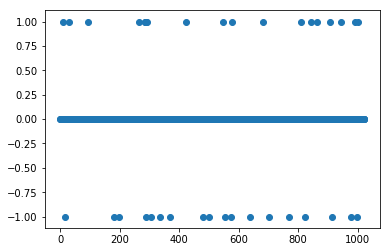

In [42]:
v_bl, v_blb, data_val = dima.funct_read(0)
blp_out = dima.blp(p,v_bl,v_blb)
cblp_out = dima.cblp(blp_out)
error = []
q_v = np.linspace(0,225,2**6)
count = 0
for i in range (0,32):
    p = np.random.randint(0,15,128)
    for x in range (0,32):
        final = dima.full_dp(x,p)
        final_digital_i = np.dot(w[x][:],p)/128

        for j in range (0,64):
            diff = final_digital_i - q_v[j]
            prev_diff = final_digital_i - q_v[j-1]
            if((prev_diff >= 0) and (diff <= 0 )):
                if(abs(prev_diff)>abs(diff)):
                    final_digital = j
                else:
                    final_digital= j-1
        error.append(final_digital - final)
        if (final_digital-final==1):
            count = count + 1 

error = np.array(error)
print(np.mean(error))
plt.scatter(np.arange(0,32*32),error)
print(final_digital,final,cblp_out)
print(count)